 # Power Load Prediction for West Zone - CNN Model

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [4]:
plot_df_west = pd.DataFrame(power_data_west, columns=['demand', 'temp', 'end', 'humidity'])

In [5]:
plot_df_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [6]:
plot_df_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [7]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [8]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [9]:
power_data_west['day_of_week'] = power_data_west['end'].dt.day_name()

In [10]:
power_data_west['day_of_week_int'] = power_data_west['end'].dt.strftime("%w")

In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_range = pd.date_range(start='2019-01-01', end='2022-01-27')

cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

power_data_west['holiday'] = power_data_west['end'].dt.date.astype('datetime64').isin(holidays)

In [12]:
power_data_west["holiday_int"] = power_data_west["holiday"].astype(int)

In [13]:
power_data_west.head(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
5,5,5,west,2019-01-29 01:15:00,2019-01-29 01:30:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
6,6,6,west,2019-01-29 01:30:00,2019-01-29 01:45:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
7,7,7,west,2019-01-29 01:45:00,2019-01-29 02:00:00,208.8,NaN,55.0,NaN,835.2,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
8,8,8,west,2019-01-29 02:00:00,2019-01-29 02:15:00,217.6,NaN,55.0,NaN,870.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0
9,9,9,west,2019-01-29 02:15:00,2019-01-29 02:30:00,229.6,NaN,55.0,NaN,918.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0


In [14]:
power_data_west.tail(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
104598,104598,104598,west,2022-01-25 13:30:00,2022-01-25 13:45:00,301.6,NaN,66.0,NaN,1206.4,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104599,104599,104599,west,2022-01-25 13:45:00,2022-01-25 14:00:00,300.0,NaN,66.0,NaN,1200.0,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104600,104600,104600,west,2022-01-25 14:00:00,2022-01-25 14:15:00,300.8,NaN,67.0,NaN,1203.2,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104601,104601,104601,west,2022-01-25 14:15:00,2022-01-25 14:30:00,309.6,NaN,67.0,NaN,1238.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104602,104602,104602,west,2022-01-25 14:30:00,2022-01-25 14:45:00,297.6,NaN,67.0,NaN,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104603,104603,104603,west,2022-01-25 14:45:00,2022-01-25 15:00:00,297.6,NaN,67.0,NaN,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104604,104604,104604,west,2022-01-25 15:00:00,2022-01-25 15:15:00,295.2,NaN,67.0,NaN,1180.8,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104605,104605,104605,west,2022-01-25 15:15:00,2022-01-25 15:30:00,304.8,NaN,67.0,NaN,1219.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104606,104606,104606,west,2022-01-25 15:30:00,2022-01-25 15:45:00,309.6,NaN,67.0,NaN,1238.4,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104607,104607,104607,west,2022-01-25 15:45:00,2022-01-25 16:00:00,296.8,NaN,67.0,NaN,1187.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0


In [15]:
power_data_west.describe()

,Unnamed: 0,index_x,usage,cost,temp,demand,index_y,dt,humidity,humidity_temp,month_int,holiday_int
count,104608.000000,104608.000000,104596.000000,0.0,104588.00000,104596.000000,104608.000000,1.046080e+05,104608.000000,104608.000000,104608.00000,104608.000000
mean,52303.500000,52303.500000,309.658615,NaN,67.39232,1238.634456,13764.530284,1.595853e+09,52.635401,68.527903,6.54298,0.027531
std,30197.872817,30197.872817,75.599852,NaN,16.59371,302.399419,7560.847033,2.721905e+07,22.815913,15.741494,3.43464,0.163627
min,0.000000,0.000000,0.000000,NaN,29.00000,0.000000,680.000000,1.548749e+09,3.000000,32.200000,1.00000,0.000000
25%,26151.750000,26151.750000,252.000000,NaN,54.00000,1008.000000,7217.750000,1.572285e+09,34.000000,55.850000,4.00000,0.000000
50%,52303.500000,52303.500000,308.000000,NaN,66.00000,1232.000000,13755.500000,1.595821e+09,49.000000,66.900000,7.00000,0.000000
75%,78455.250000,78455.250000,368.000000,NaN,79.00000,1472.000000,20317.250000,1.619443e+09,70.000000,80.550000,10.00000,0.000000
max,104607.000000,104607.000000,531.200000,NaN,114.00000,2124.800000,26903.000000,1.643152e+09,100.000000,110.680000,12.00000,1.000000


In [16]:
power_data_west.shape

(104608, 23)

In [17]:
power_data_west.dtypes

Unnamed: 0                  int64
index_x                     int64
service                    object
start                      object
end                datetime64[ns]
usage                     float64
cost                      float64
temp                      float64
event_flag                 object
demand                    float64
sfm                        object
index_y                     int64
dt                          int64
dt_iso                     object
humidity                    int64
humidity_temp             float64
pt_date                    object
month                      object
month_int                    Int8
day_of_week                object
day_of_week_int            object
holiday                      bool
holiday_int                 int64
dtype: object

In [18]:
#For checking missing values in dataset
power_data_west.isna().sum()

Unnamed: 0              0
index_x                 0
service                 0
start                   0
end                     0
usage                  12
cost               104608
temp                   20
event_flag         104602
demand                 12
sfm                     0
index_y                 0
dt                      0
dt_iso                  0
humidity                0
humidity_temp           0
pt_date                 0
month                   0
month_int               0
day_of_week             0
day_of_week_int         0
holiday                 0
holiday_int             0
dtype: int64

In [19]:
power_data_west.fillna(method='ffill',inplace=True)
power_data_west.isna().sum()

Unnamed: 0              0
index_x                 0
service                 0
start                   0
end                     0
usage                   0
cost               104608
temp                    0
event_flag           3840
demand                  0
sfm                     0
index_y                 0
dt                      0
dt_iso                  0
humidity                0
humidity_temp           0
pt_date                 0
month                   0
month_int               0
day_of_week             0
day_of_week_int         0
holiday                 0
holiday_int             0
dtype: int64

In [20]:
zero_usage_df = power_data_west.loc[power_data_west['demand'] == 0]
zero_usage_df.count()

Unnamed: 0         50
index_x            50
service            50
start              50
end                50
usage              50
cost                0
temp               50
event_flag         50
demand             50
sfm                50
index_y            50
dt                 50
dt_iso             50
humidity           50
humidity_temp      50
pt_date            50
month              50
month_int          50
day_of_week        50
day_of_week_int    50
holiday            50
holiday_int        50
dtype: int64

In [21]:
power_data_west = power_data_west[power_data_west['demand'] != 0]
zero_usage_df = power_data_west.loc[power_data_west['demand'] == 0]
zero_usage_df.count()

Unnamed: 0         0
index_x            0
service            0
start              0
end                0
usage              0
cost               0
temp               0
event_flag         0
demand             0
sfm                0
index_y            0
dt                 0
dt_iso             0
humidity           0
humidity_temp      0
pt_date            0
month              0
month_int          0
day_of_week        0
day_of_week_int    0
holiday            0
holiday_int        0
dtype: int64

dataset.kW.plot()

## CNN Timeseries Model

In [22]:
cnn_data = power_data_west[(power_data_west['end'] > '2019-01-01') & (power_data_west['end'] < '2022-02-01')]

In [23]:
cnn_data.head(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
5,5,5,west,2019-01-29 01:15:00,2019-01-29 01:30:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
6,6,6,west,2019-01-29 01:30:00,2019-01-29 01:45:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
7,7,7,west,2019-01-29 01:45:00,2019-01-29 02:00:00,208.8,NaN,55.0,NaN,835.2,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
8,8,8,west,2019-01-29 02:00:00,2019-01-29 02:15:00,217.6,NaN,55.0,NaN,870.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0
9,9,9,west,2019-01-29 02:15:00,2019-01-29 02:30:00,229.6,NaN,55.0,NaN,918.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0


In [24]:
cnn_data.tail(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
104598,104598,104598,west,2022-01-25 13:30:00,2022-01-25 13:45:00,301.6,NaN,66.0,Daylight Savings,1206.4,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104599,104599,104599,west,2022-01-25 13:45:00,2022-01-25 14:00:00,300.0,NaN,66.0,Daylight Savings,1200.0,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104600,104600,104600,west,2022-01-25 14:00:00,2022-01-25 14:15:00,300.8,NaN,67.0,Daylight Savings,1203.2,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104601,104601,104601,west,2022-01-25 14:15:00,2022-01-25 14:30:00,309.6,NaN,67.0,Daylight Savings,1238.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104602,104602,104602,west,2022-01-25 14:30:00,2022-01-25 14:45:00,297.6,NaN,67.0,Daylight Savings,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104603,104603,104603,west,2022-01-25 14:45:00,2022-01-25 15:00:00,297.6,NaN,67.0,Daylight Savings,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104604,104604,104604,west,2022-01-25 15:00:00,2022-01-25 15:15:00,295.2,NaN,67.0,Daylight Savings,1180.8,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104605,104605,104605,west,2022-01-25 15:15:00,2022-01-25 15:30:00,304.8,NaN,67.0,Daylight Savings,1219.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104606,104606,104606,west,2022-01-25 15:30:00,2022-01-25 15:45:00,309.6,NaN,67.0,Daylight Savings,1238.4,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104607,104607,104607,west,2022-01-25 15:45:00,2022-01-25 16:00:00,296.8,NaN,67.0,Daylight Savings,1187.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0


In [25]:
cnn_data_mod = cnn_data[['demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [26]:
cnn_data_mod.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,844.8,54.0,21,1,2,0
1,841.6,54.0,21,1,2,0
2,832.0,54.0,21,1,2,0
3,848.0,54.0,21,1,2,0
4,812.8,55.0,21,1,2,0
5,822.4,55.0,21,1,2,0
6,822.4,55.0,21,1,2,0
7,835.2,55.0,21,1,2,0
8,870.4,55.0,22,1,2,0
9,918.4,55.0,22,1,2,0


In [27]:
cnn_data_mod.tail(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
104598,1206.4,66.0,37,1,2,0
104599,1200.0,66.0,37,1,2,0
104600,1203.2,67.0,27,1,2,0
104601,1238.4,67.0,27,1,2,0
104602,1190.4,67.0,27,1,2,0
104603,1190.4,67.0,27,1,2,0
104604,1180.8,67.0,26,1,2,0
104605,1219.2,67.0,26,1,2,0
104606,1238.4,67.0,26,1,2,0
104607,1187.2,67.0,26,1,2,0


In [28]:
cnn_timestep_data = cnn_data_mod.copy()
cnn_timestep_data.head(12)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,844.8,54.0,21,1,2,0
1,841.6,54.0,21,1,2,0
2,832.0,54.0,21,1,2,0
3,848.0,54.0,21,1,2,0
4,812.8,55.0,21,1,2,0
5,822.4,55.0,21,1,2,0
6,822.4,55.0,21,1,2,0
7,835.2,55.0,21,1,2,0
8,870.4,55.0,22,1,2,0
9,918.4,55.0,22,1,2,0


In [29]:
from numpy import array
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    #print('Len >> ', len(sequences))
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        #print(end_ix)
        # check if we are beyond the dataset
        if end_ix+1 >= len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:6], sequences[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [30]:
X,y = split_sequences(cnn_timestep_data.to_numpy(), 2880)

In [31]:
X.shape

(101677, 2880, 6)

In [32]:
y.shape

(101677,)

In [33]:
X = X.reshape((101677, 17280))

In [34]:
from sklearn.preprocessing import MinMaxScaler

n_train_hours = 2 * 365 * 24 * 4
X_train = X[:n_train_hours, :]
X_test = X[n_train_hours:, :]

y_train = y[:n_train_hours]
y_test = y[n_train_hours:]

X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_np= y_train.reshape((y_train.shape[0],1))
y_train_scaled = y_scaler.fit_transform(y_train_np)

y_test_np= y_test.reshape((y_test.shape[0],1))
y_test_scaled = y_scaler.transform(y_test_np)

# reshape input to be 3D [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 2880, 6))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 2880, 6))
print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)

(70080, 2880, 6) (70080, 1) (31597, 2880, 6) (31597, 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from keras.callbacks import ModelCheckpoint


# design network
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Conv1D(filters=100, kernel_size=2, activation='relu', 
           input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5000, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mae', optimizer='adam')

filepath="cnnmodel_15m_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit network
history = model.fit(X_train_scaled, y_train_scaled, epochs=30, batch_size=100, 
                    validation_data=(X_test_scaled, y_test_scaled), verbose=2, shuffle=False, callbacks=callbacks_list)

Using TensorFlow backend.


[2022-03-30 18:04:50.409 ip-172-16-21-10:24919 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-30 18:04:50.472 ip-172-16-21-10:24919 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train on 70080 samples, validate on 31597 samples
Epoch 1/30

Epoch 00002: val_loss did not improve from 0.12160
70080/70080 - 1972s - loss: 0.0679 - val_loss: 0.1361
Epoch 3/30

Epoch 00003: val_loss did not improve from 0.12160
70080/70080 - 1981s - loss: 0.0734 - val_loss: 0.1246
Epoch 4/30

Epoch 00004: val_loss improved from 0.12160 to 0.11001, saving model to cnnmodel_15m_best.hdf5
70080/70080 - 2033s - loss: 0.0782 - val_loss: 0.1100
Epoch 5/30

Epoch 00005: val_loss improved from 0.11001 to 0.09844, saving model to cnnmodel_15m_best.hdf5
70080/70080 - 2025s - loss: 0.0596 - val_loss: 0.0984
Epoch 6/30

Epoch 00006: val_loss did not improve from 0.09844
70080/70080 - 1970s - loss: 0.0502 - val_loss: 0.1097
Epoc

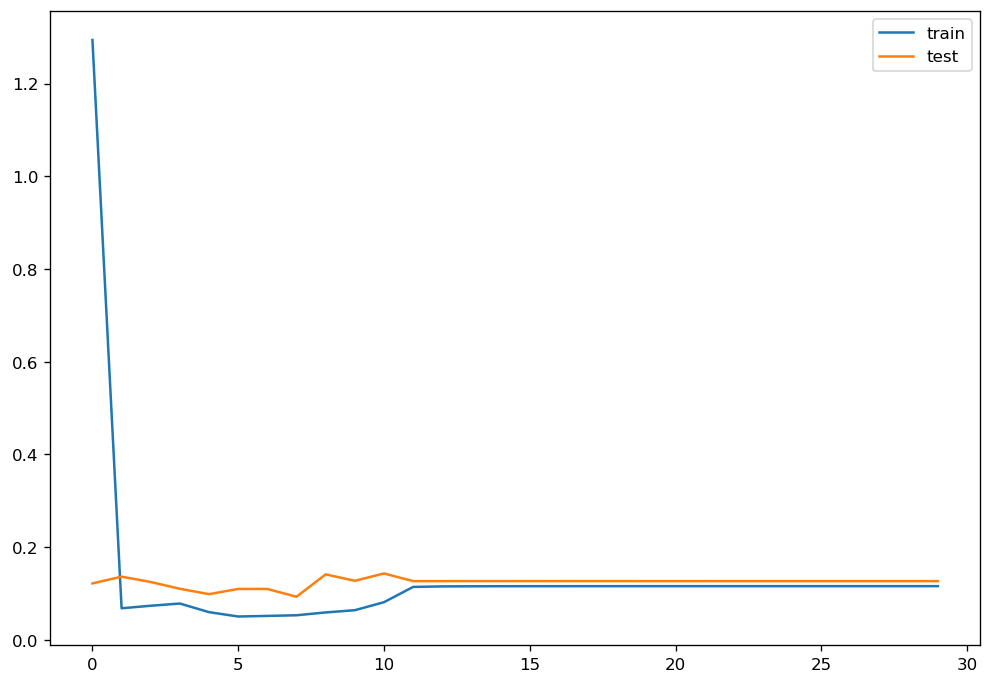

In [41]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [36]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from keras.callbacks import ModelCheckpoint


model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Conv1D(filters=100, kernel_size=2, activation='relu', 
           input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5000, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.load_weights("cnnmodel_15m_best.hdf5")

model.compile(loss='mae', optimizer='adam')

model.summary()

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2879, 100)         1300      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1439, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 143900)            0         
_________________________________________________________________
dense (Dense)                (None, 5000)              719505000 
_________________________________________________________________
dense_1 (Dense)              (None, 100)               500100    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 720,006,501
Trainable params: 720,006,501
Non-trainable params: 0
__________________________________________

In [37]:
model.evaluate(X_test_scaled, y_test_scaled, verbose=1)

[2022-03-31 19:29:32.327 ip-172-16-21-10:10083 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-31 19:29:32.391 ip-172-16-21-10:10083 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
31597/31597 [==============================] - 191s 6ms/sample - loss: 0.0929


0.09287650297042568

In [38]:
# make a prediction
print('Running Prediction')
y_pred = model.predict(X_test_scaled)
print('Done')

Running Prediction
Done


In [41]:
y_pred.shape

(31597, 1)

In [42]:
inv_y_pred=  y_scaler.inverse_transform(y_pred)
inv_y_pred.shape

(31597, 1)

In [43]:
final_df = pd.concat([pd.DataFrame(y_test, columns = ['Actual Peak Demand']), pd.DataFrame(inv_y_pred, columns = ['Predicted Peak Demand'])], axis=1)
final_df

,Actual Peak Demand,Predicted Peak Demand
0,1027.2,1125.782227
1,1100.8,1124.633545
2,1091.2,1125.082153
3,1104.0,1126.118042
4,1081.6,1126.898438
...,...,...
31592,1190.4,1214.943970
31593,1190.4,1214.473511
31594,1180.8,1214.623291
31595,1219.2,1216.051758


In [44]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [46]:
mean_absolute_error_var = mean_absolute_error(final_df['Actual Peak Demand'], final_df['Predicted Peak Demand'])
mean_absolute_percentage_error_var = mean_absolute_percentage_error(final_df['Actual Peak Demand'], final_df['Predicted Peak Demand'])
mse_error_var = mean_squared_error(final_df['Actual Peak Demand'], final_df['Predicted Peak Demand'], squared=True)
rmse_error_var = mean_squared_error(final_df['Actual Peak Demand'], final_df['Predicted Peak Demand'], squared=False)

In [47]:
print('Test Set Metrics')
print('MAPE: ' , mean_absolute_percentage_error_var)
print('MAE: ', mean_absolute_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

Test Set Metrics
MAPE:  4.196688658194607
MAE:  184.26698215993977
MSE:  56622.0060677479
RMSE:  237.95378977387165


<AxesSubplot:>

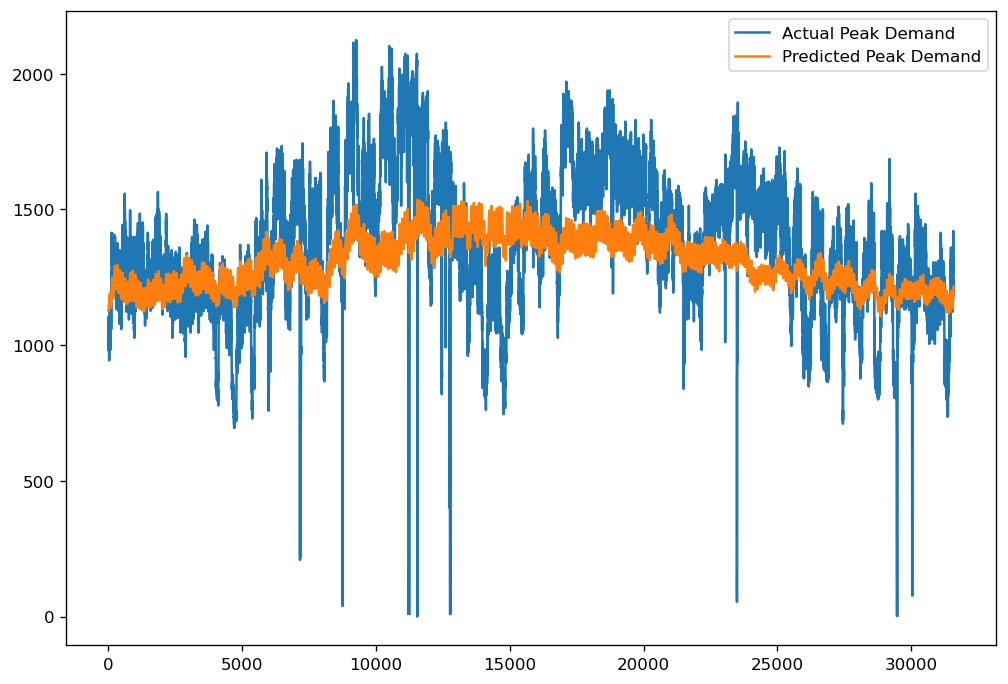

In [48]:
final_df.plot()

<AxesSubplot:>

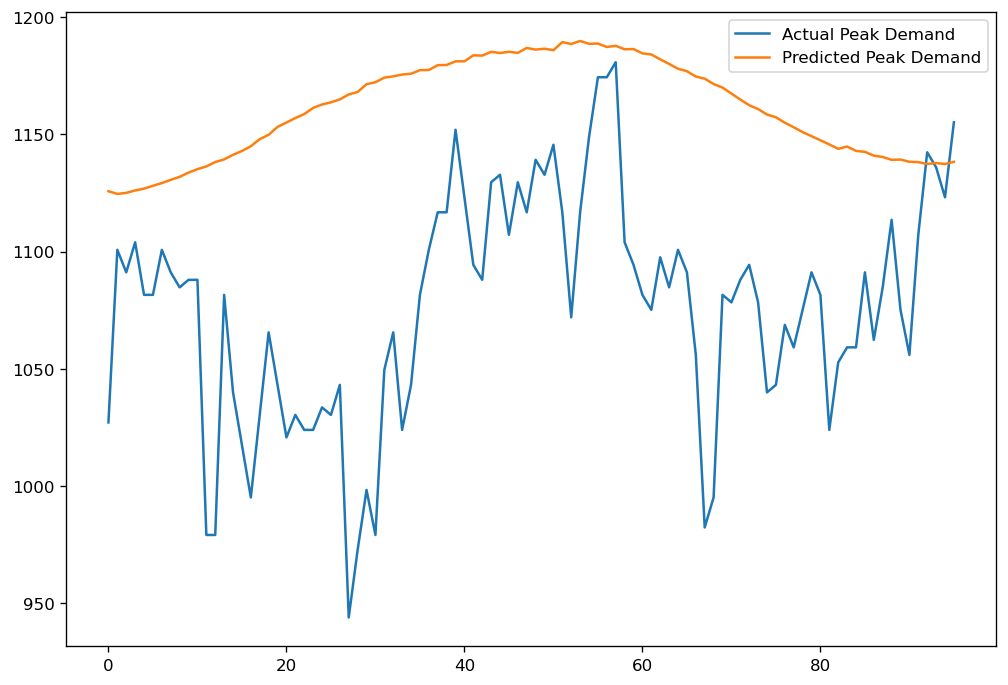

In [49]:
final_df.head(96).plot()

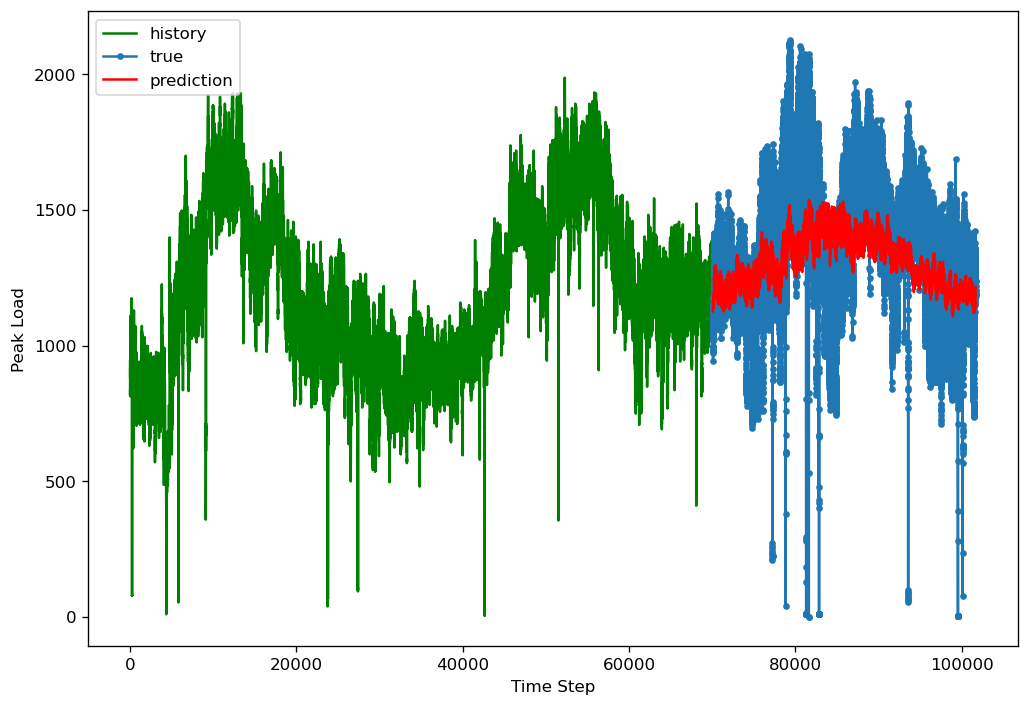

In [50]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train),  len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train),  len(y_train) + len(y_test)), inv_y_pred, 'r', label="prediction")
plt.ylabel('Peak Load')
plt.xlabel('Time Step')
plt.legend()
plt.show();